In [14]:
from langchain_community.document_loaders import UnstructuredPDFLoader
from src.utils import save_docs_to_jsonl

import os
from tqdm.auto import tqdm
from langchain_community.document_loaders import PyPDFLoader
from typing import List
import re
from copy import copy as CP
import numpy as np
import matplotlib.pyplot as plt

# Loading

In [2]:
# locations
cwd = os.getcwd()
doc_loc = "data/UL9540_3.pdf"

In [3]:
loader2 = UnstructuredPDFLoader(os.path.join(cwd, doc_loc))
pages = loader2.load_and_split()

print(f"Loaded {len(pages)} pages")  

Loaded 79 pages


## Cleaning up

In [4]:
def clean_text(txt: str, patterns: List[str], matchers: List = []) -> str:
    """ Replaces patterns in the patterns with empty strings """
    for i, pat in enumerate(patterns):
        txt = txt.replace(pat, '')
    if len(matchers)>0:
        for matcher in matchers:
            if type(matcher) != None:
                txt = matcher.sub("", txt)
    return txt

def custom_sentence_splitter(text: str) -> List[str]:
    return re.split(r"\.\n", text)

In [5]:
# the document most likely will contain various copyright information that will confuse the LLM
# inspect it and define proper patterns/strings
# some of the patterns could be RegEx patterns
# the wrapper clean_text() accepts both list of strings for replacement (1:1 match) and re.compile() patterns

# these are examples of the strings you would like to remove
core_string1 = """string1"""
core_string2 = "ANSI/CAN/UL 9540\n\n"
core_string3 = "1 0 : 1 7 A M"
core_string4 = """\nl\n"""
strings = [core_string0, core_string1, core_string2, core_string3, core_string4]

# ReGex matchers
matchers = [
    re.compile(r"\n\d+\n"),
    re.compile(r"(\n){3}")
]

In [6]:
doc_name = "UL9540" #our source 
for i, page in enumerate(pages):
    page.page_content = clean_text(page.page_content, strings, matchers)
    page.metadata['source'] = doc_name

In [ ]:
preparsed_loc = "preparsed_datadata/ul9540_pages.jsonl"
save_docs_to_jsonl(pages, os.path.join(cwd, preparsed_loc))

# Split each page

We will use combination of Semantic and Recursive text splitters. In our case the semantic splitter produces chunks of data without abrupt splittings of paragraphs. Unfortunately, it tends to produce sometimes very large chunks, which are no good for both inference performance and information extraction perspectives. Therefore we will do several passes recusrsively on the splits. If there are some documents left longer than we would like to, then we can apply simple recursive splitter to these.
<br><br>
5 iterations seems to be enoug to leave approx. 5.8% of larger chunks

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.storage import LocalFileStore

In [8]:
def recursive_semant_splitter(docs, splitter, max_len, depth=2):
    first_split = []
    for dc in tqdm(docs, leave=True):
        first_split += splitter.transform_documents([dc])
        
    sem_split_docs = first_split
    if depth>1:
        for _ in tqdm(range(depth)):
            len_dist = count_lengths(sem_split_docs)
            if np.max(len_dist)<=max_len:
                break
            sem_split_docs = _split_semant_rec(sem_split_docs, splitter, max_len)
    return sem_split_docs            

def _split_semant_rec(docs, splitter, max_len):
    docs2split = []
    unsplitted = []
    for dc in docs:
        if len(dc.page_content) > max_len:
            docs2split.append(dc)
        else:
            unsplitted += [dc]
    t = splitter.transform_documents(docs2split)
    return unsplitted + t

def count_lengths(docs):
    lens = []
    for doc in docs:
        lens.append(len(doc.page_content))
    return np.array(lens, dtype = int)

In [36]:
chunk_size = 1024
min_len = 256
depths = 5
chunk_overlap = 128

rec_splitter = RecursiveCharacterTextSplitter(
    chunk_size = chunk_size, # the character length of the chunk
    chunk_overlap = chunk_overlap, # the character length of the overlap between chunks
    length_function = len, # the length function - in this case, character length (aka the python len() fn.)
)

In [10]:
# Choose your embedding model
embed_model_id = 'BAAI/bge-large-en-v1.5'

# It's a good idea to cache the model
# so you do not download it every time you instantiate it
model_cache =  '/models/model_cache' 

# location for the embeddings cache
# it's a good idea to have
embed_cache = "./cache"
store = LocalFileStore(embed_cache)

# any model kwargs
# in our case only to use a GPU
model_kwargs = {'device': 'cuda', 
               }

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id, cache_folder=model_cache,
    model_kwargs=model_kwargs,
    show_progress=False # set to False if you do not want to see the progress
)

embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

semantic_splitter = SemanticChunker(core_embeddings_model)

In [37]:
%%time
# do the recursive semantic splitting
sem_split_docs = recursive_semant_splitter(pages, semantic_splitter, chunk_size, depths)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 37.9 s, sys: 291 ms, total: 38.1 s
Wall time: 36.8 s


(429,)
Percentage of the documents larger than 1024: 5.83%


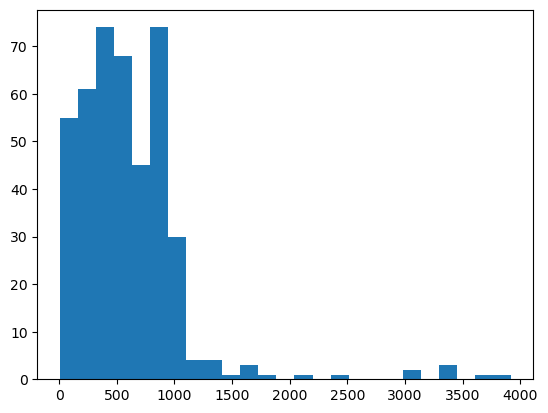

In [38]:
# plot the distribution of the resulting sizes of the documents
ls = count_lengths(sem_split_docs)
print(ls.shape)
_ = plt.hist(ls, bins=25)
print(f"Percentage of the documents larger than {chunk_size}: {ls[ls>chunk_size].shape[0]/ls.shape[0]*100:.2f}%")

There are still documents too large. We will split them using the simple recursive splitter defined above

In [24]:
final_semantic_split = []
for dc in sem_split_docs:
    if len(dc.page_content)>chunk_size:
        final_semantic_split += rec_splitter.transform_documents([dc])
    else:
        final_semantic_split += [dc]

(479,)
Percentage of the documents larger than 1024: 0.00%


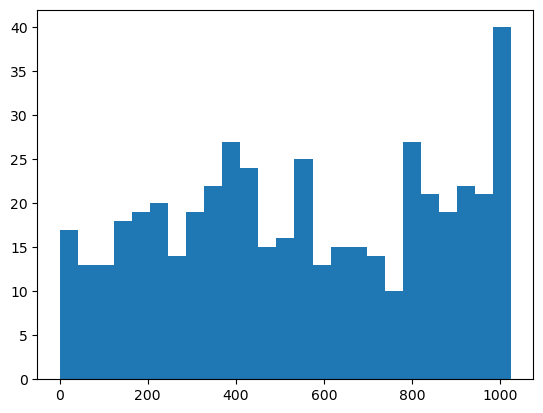

In [29]:
# plot the distribution of the final documents
ls = count_lengths(final_semantic_split)
print(ls.shape)
_ = plt.hist(ls, bins = 25)
print(f"Percentage of the documents larger than {chunk_size}: {ls[ls>chunk_size].shape[0]/ls.shape[0]*100:.2f}%")

In [ ]:
from copy import copy as CP

In [30]:
# finally, add document name and section to the actual document text to help retrieval
docs = CP(final_semantic_split)
for dc in docs:
    text = dc.page_content
    meta = dc.metadata
    dc.page_content = f"Regulation: {meta['source']}\n-----------\n{text}"

In [31]:
final_doc_name = f"{doc_name}_parsed_semantic_max-{chunk_size}-overlap-{chunk_overlap}_depth-{depths}.jsonl"
preparsed_loc = "preparsed_datadata"
save_docs_to_jsonl(docs, os.path.join(cwd, *(preparsed_loc, final_doc_name)))

In [32]:
## just a simple recursice chunking
rec_split_docs = rec_splitter.transform_documents(pages)

final_doc_name = f"{doc_name}_parsed_recursive_max-{chunk_size}-overlap-{chunk_overlap}.jsonl"
preparsed_loc = "preparsed_datadata"
save_docs_to_jsonl(rec_split_docs, os.path.join(cwd, *(preparsed_loc, final_doc_name)))